In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        !pip3 install opencv-python
!pip3 install matplotlib 

In [1]:
import cv2
from matplotlib import pyplot as plt 
import numpy as np


In [2]:
def fix_image_to_show(img):
    image = img.copy()
    image = image.astype('float32')
    max_pixel = np.max(image)
    min_pixel = np.min(image)
    if max_pixel == min_pixel:
        image[:, :, :] = 127
        image = image.astype('uint8')
        return image
    m = 255 / (max_pixel - min_pixel)
    image = image * m - min_pixel * m
    image = image.astype('uint8')
    return image

def show_image(img, name=None, cmap=None):
    image = img.copy()
    image = fix_image_to_show(image)
    plt.imshow(image, vmin=0, vmax=255, cmap=cmap)
    plt.show()
    if name is not None :
        plt.imsave(name + '.jpg', image, cmap=cmap)

In [3]:
video = cv2.VideoCapture('resources/video.mp4')
frames = [] 
while video.isOpened():
    ret, frame = video.read() 
    if not ret: 
        break
    frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

video.release() 
cv2.destroyAllWindows()

In [4]:
def get_homography(image1, image2):
    sift = cv2.SIFT_create()
    kp1, desc1 = sift.detectAndCompute(image1, None)
    kp2, desc2 = sift.detectAndCompute(image2, None)

    bf_matcher = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf_matcher.match(desc1, desc2)

    match_list1 = np.zeros((len(matches), 1, 2), dtype='float32')
    match_list2 = np.zeros((len(matches), 1, 2), dtype='float32')
    for i in range(len(matches)):
        match = matches[i]
        match_list1[i] = kp1[match.queryIdx].pt
        match_list2[i] = kp2[match.trainIdx].pt
    
    homography, mask = cv2.findHomography(match_list1, match_list2, cv2.RANSAC, maxIters=300 * 1000, ransacReprojThreshold=5)
    return homography



In [5]:
def imply_homography_to_points(points, homography): 
    res_points = np.transpose(np.matmul(homography, np.transpose(points)))
    res_points[:, 0] /= res_points[:, 2]
    res_points[:, 1] /= res_points[:, 2]
    return res_points[:, :-1].astype('int32')

In [7]:

homography_270_to_450 = get_homography(frames[270], frames[450])


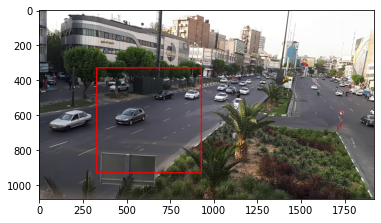

[[ 723  363]
 [1296  354]
 [1287  970]
 [ 714  922]]


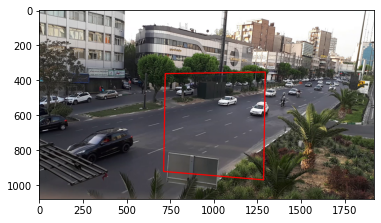

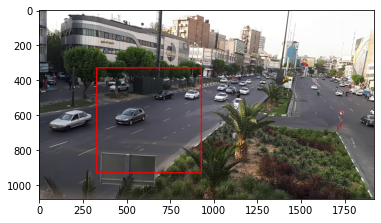

[[ 723  363]
 [1296  354]
 [1287  970]
 [ 714  922]]


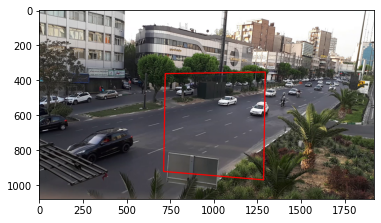

In [9]:
square_pt1 = (330, 330)
square_pt2 = (930, 930)

image_450_rect = cv2.rectangle(frames[450].copy(), square_pt1, square_pt2, color=(255, 0, 0), thickness=5)

show_image(image_450_rect, name='res01-450-rect')

square_homography = imply_homography_to_points(
    np.asarray([
        [330, 330, 1],
        [930, 330, 1],
        [930, 930, 1],
        [330, 930, 1],
    ], dtype='float32'), 
    np.linalg.inv(homography_270_to_450)
)

image_270_rect = cv2.polylines(frames[270].copy(), [square_homography], True, (255, 0, 0), thickness=5)

show_image(image_270_rect, name='res02-270-rect')
square_pt1 = (330, 330)
square_pt2 = (930, 930)

image_450_rect = cv2.rectangle(frames[450].copy(), square_pt1, square_pt2, color=(255, 0, 0), thickness=5)

show_image(image_450_rect, name='res01-450-rect')

square_homography = imply_homography_to_points(
    np.asarray([
        [330, 330, 1],
        [930, 330, 1],
        [930, 930, 1],
        [330, 930, 1],
    ], dtype='float32'), 
    np.linalg.inv(homography_270_to_450)
)


image_270_rect = cv2.polylines(frames[270].copy(), [square_homography], True, (255, 0, 0), thickness=5)

show_image(image_270_rect, name='res02-270-rect')

In [6]:
def imply_homography_to_image(image, homography, size): 
    translation_mat = np.asarray([
        [1, 0, 2000],
        [0, 1, 600],
        [0, 0, 1],
    ], dtype='float32')
    
    if homography is not None: 
        homography = np.matmul(translation_mat, homography)
    else:
        homography = translation_mat
    
    warp_image = cv2.warpPerspective(image.copy(), homography, size)
    return warp_image

In [7]:
def reduce_image(image):
    ind = np.argwhere(image > 0)
    min_values = ind.min(axis=0)
    max_values = ind.max(axis=0)
    
    return image[min_values[0]: max_values[0], min_values[1]: max_values[1], :]

In [7]:
def get_translated_homography(image, homography):
    points_homography = imply_homography_to_points(
        np.asarray([
            [0, 0, 1],
            [image.shape[0], 0, 1],
            [0, image.shape[1], 1],
            [image.shape[0], image.shape[1], 1]
        ]), 
        homography
    )
    
    min_values = points_homography.min(axis=0)
    tx = 0
    if min_values[0] < 0:
        tx = -min_values[0]
    ty = 0
    if min_values[1] < 0:
        ty = -min_values[1]
    
    translation_mat = np.asarray([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1],
    ], dtype='float32')
    
    homography = np.matmul(translation_mat, homography)
    
    return homography, translation_mat

def warp_image(image1, image2, homography=None): 
    image1 = image1.copy()
    image2 = image2.copy()
    if homography is None:
        homography = get_homography(image1, image2)
        
    homography, translation_mat = get_translated_homography(image1, homography)
    
    tx = translation_mat[0, 2]
    ty = translation_mat[1, 2]
    
    
    result_image = cv2.warpPerspective(image1, homography, (image1.shape[1] + image2.shape[1], image1.shape[0] + image2.shape[0]))
    show_image(result_image)
    return result_image, int(tx), int(ty), homography


def simple_merge_images(image1, image2, homography=None): 
    result_image, tx, ty, homography = warp_image(image1, image2, homography)
    show_image(result_image)
    result_image[ty: ty + image2.shape[0], tx: tx + image2.shape[1]] = image2
    return result_image

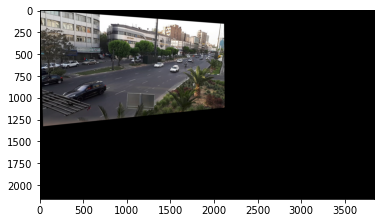

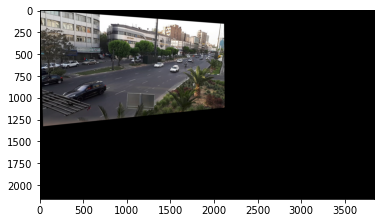

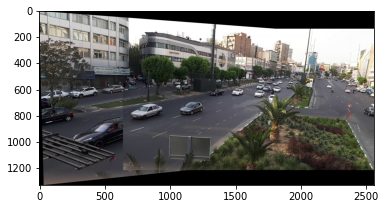

In [13]:
panaroma_image_270_450 = simple_merge_images(frames[270], frames[450], homography_270_to_450)
panaroma_image_270_450 = reduce_image(panaroma_image_270_450)
show_image(panaroma_image_270_450, name='res03-270-450-panaroma')

In [14]:
def blending(image1, image2):
#     return cv2.blur(image2.copy(), (5, 5))
    size = (image1.shape[0], image1.shape[1], 3)
    mask = np.meshgrid(np.arange(0, 255, 255/size[1]), np.arange(size[0]))
    mask = np.asarray(mask)
    mask = mask[0, :, :]
    result_mask = np.zeros((size[0], size[1], 3), dtype='float32')
    result_mask[:, :, 0] = result_mask[:, :, 1] = result_mask[:, :, 2] = mask 
    result_mask = result_mask / 255 
    ones = np.ones(size, dtype='float32')
    result = (ones - result_mask) * image1 + result_mask * image2 
    return result.astype('uint8')

In [8]:
homographies = np.zeros((900, 3, 3), dtype='float32')
mark = np.zeros((900), dtype='uint8')
homographies.fill(-1)
homographies[450] = np.asarray(
[
    [1, 0, 0], 
    [0, 1, 0],
    [0, 0, 1], 
], dtype='float32')

def get_frame_key(ind): 
    if ind <= 90:
        return 90
    if ind <= 270:
        return 270 
    if ind <= 630:
        return ind 
    if ind >= 810:
        return 810
    # 630 < ind < 810 
    return 630 

def get_frames_homography(ind1):
    ind2 = 450
    key_frame_ind = get_frame_key(ind1)
    if ind1 == 450:
        return None
    if mark[ind1] == 1: 
        return homographies[ind1]
    if key_frame_ind == None or ind1 == key_frame_ind:
        homographies[ind1, :, :] = get_homography(frames[ind1], frames[ind2])
    else:
        homography = get_homography(frames[ind1], frames[key_frame_ind])
        homography = np.matmul(homography, get_frames_homography(key_frame_ind))
        homographies[ind1, :, :] = homography
    mark[ind1] = 1 
    return homographies[ind1, :, :]



In [9]:
def get_result_image_size(image, mat): 
    points = imply_homography_to_points(
        np.asarray([
            [0, 0, 1],
            [image.shape[1], 0, 1],
            [0, image.shape[0], 1],
            [image.shape[1], image.shape[0], 1]
        ], dtype='float32'), 
        mat
    )
    
    max_values = points.max(axis=0)
    return (max_values[0], max_values[1])

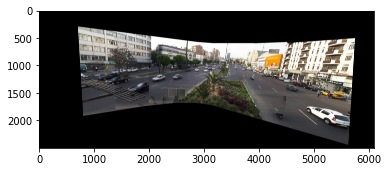

In [17]:
result_image = np.zeros((2500, 6100, 3), dtype='float32')

def merge_image(ind, res_image, result_mask, homography=None, status=False): 
    if homography is None:
        homography = get_frames_homography(ind)
    
    
    image = frames[ind].copy()
    res_image = res_image.copy()
    homo_image = imply_homography_to_image(image, homography, (res_image.shape[1], res_image.shape[0]))
    image_mask = np.ones((image.shape[0], image.shape[1], 3), dtype='float32')
    image_mask = imply_homography_to_image(image_mask, homography, (res_image.shape[1], res_image.shape[0])).astype('uint8')
    
    
    mask = np.bitwise_and(result_mask, image_mask)
        
    if status is False:    
        res_image[mask == 0] += homo_image[mask == 0]
    else:
        res_image += homo_image
    res_image[res_image > 255] = 255
        
    return res_image, image_mask
    



result_mask = np.ones((frames[450].shape[0], frames[450].shape[1], 3), dtype='uint8')
result_mask = imply_homography_to_image(result_mask, None, (result_image.shape[1], result_image.shape[0]))
result_image, result_mask = merge_image(450, result_image, result_mask, homography=None, status=True)
result_image, result_mask = merge_image(270, result_image, result_mask, homography_270_to_450)
result_image, result_mask = merge_image(90, result_image, result_mask, get_frames_homography(90))
result_mask = np.ones((frames[450].shape[0], frames[450].shape[1], 3), dtype='uint8')
result_mask = imply_homography_to_image(result_mask, None, (result_image.shape[1], result_image.shape[0]))
result_image, result_mask = merge_image(630, result_image, result_mask, get_frames_homography(630))
result_image, result_mask = merge_image(810, result_image, result_mask, get_frames_homography(810))
show_image(result_image, name='res04-key-frames-panaroma')

In [ ]:
for i in range(900):
    if i == 450:
        continue
    get_frames_homography(i)
np.save('homographies.npy', homographies)


In [9]:
homographies = np.load('homographies.npy')

scale_mat = np.asarray([
    [480/1080, 0, 0], 
    [0, 480/1080, 0],
    [0, 0, 1], 
], dtype='float32')

inv_scale = np.linalg.inv(scale_mat)

for i in range(900): 
    homographies[i] = np.matmul(inv_scale, np.matmul(homographies[i], scale_mat))

In [ ]:

writer = cv2.VideoWriter('res05-refrences-plane.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (6100, 2500))

for i in range(900):
    image_i = imply_homography_to_image(frames[i].copy(), homographies[i], (6100, 2500)).astype('uint8')
    image_i = cv2.cvtColor(image_i, cv2.COLOR_RGB2BGR)
    writer.write(image_i)
writer.release()